In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()
print(repo_root)

expression_path = repo_root / os.getenv("EM_COLLAPSED")
clinical_path = repo_root / os.getenv("CLINICAL_LLM")

expression = pd.read_csv(expression_path, index_col=0)
clinical = pd.read_csv(clinical_path, index_col=0)


/Users/sarah/Code/bioinformatics-tool


In [11]:
target = 'overall survival days'  # Adjust if column name differs

In [21]:
clinical[target].describe()

count    3409.000000
mean     1594.341742
std       494.185586
min        56.000000
25%      1212.000000
50%      1596.000000
75%      2004.000000
max      2474.000000
Name: overall survival days, dtype: float64

In [12]:
# Select numeric clinical features
clinical_numeric = clinical[[col for col in clinical.columns if pd.api.types.is_numeric_dtype(clinical[col])]]

# Select top 8000 most variable genes
gene_variances = expression.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(8000).index
expression_top = expression[top_genes]

# Combine with clinical features
combined = pd.concat([clinical_numeric, expression_top], axis=1, join='inner')

In [17]:
# Drop target from X if present
if target in combined.columns:
    combined = combined.drop(columns=[target])

# Target variable
y = clinical.loc[combined.index, target]

# Drop rows with missing target
combined = combined.loc[y.notnull()]
y = y.loc[y.notnull()]

# Fill missing values
X = combined.fillna(combined.mean())
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting - MSE: {mse_gb:.2f}, R^2: {r2_gb:.2f}')

Gradient Boosting - MSE: 58677.15, R^2: 0.77


In [22]:
from sklearn.preprocessing import StandardScaler

# Drop target from X if present
if target in combined.columns:
    combined = combined.drop(columns=[target])

# Target variable
y = clinical.loc[combined.index, target]

# Drop rows with missing target
combined = combined.loc[y.notnull()]
y = y.loc[y.notnull()]

# Fill missing values
X = combined.fillna(combined.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Try GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting - MSE: {mse_gb:.2f}, R^2: {r2_gb:.2f}')

Gradient Boosting - MSE: 57176.93, R^2: 0.77


In [8]:
clinical[target].describe()

count    3409.000000
mean     1594.341742
std       494.185586
min        56.000000
25%      1212.000000
50%      1596.000000
75%      2004.000000
max      2474.000000
Name: overall survival days, dtype: float64

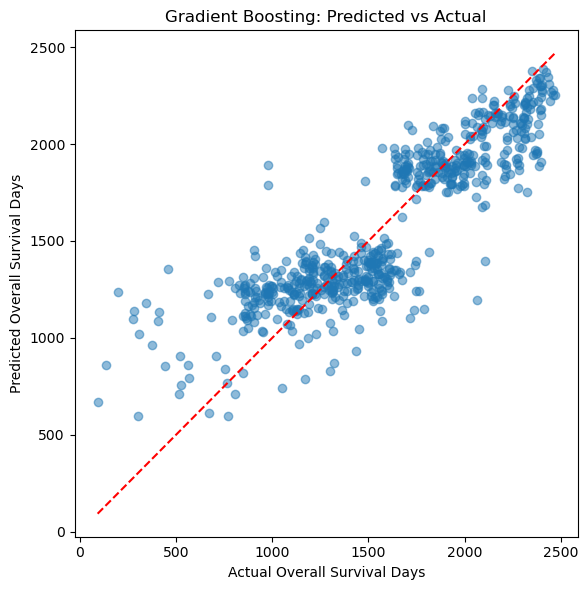

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Overall Survival Days')
plt.ylabel('Predicted Overall Survival Days')
plt.title('Gradient Boosting: Predicted vs Actual')
plt.tight_layout()
plt.show()

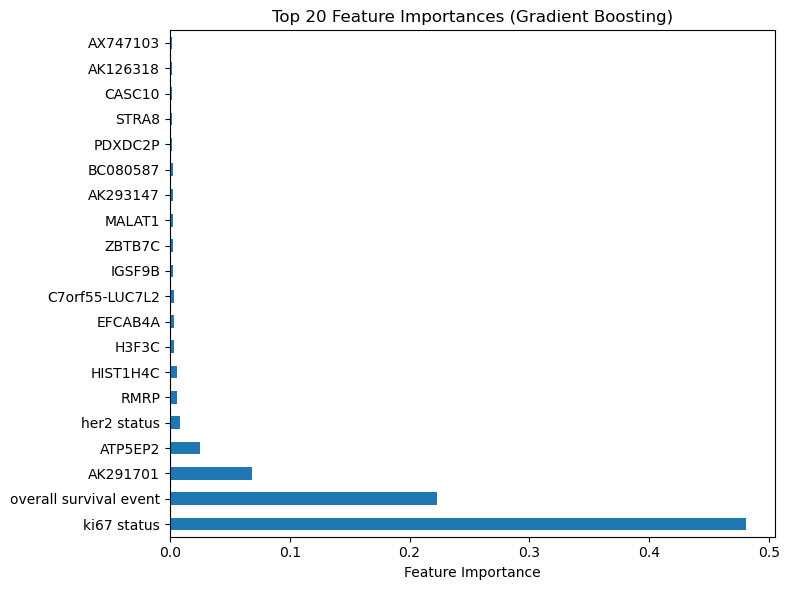

In [19]:
# Plot feature importances from GradientBoostingRegressor
importances = pd.Series(gb_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(8, 6))
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()

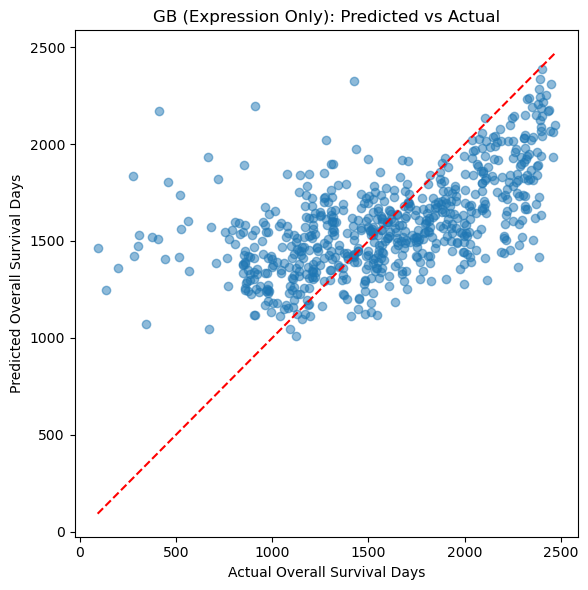

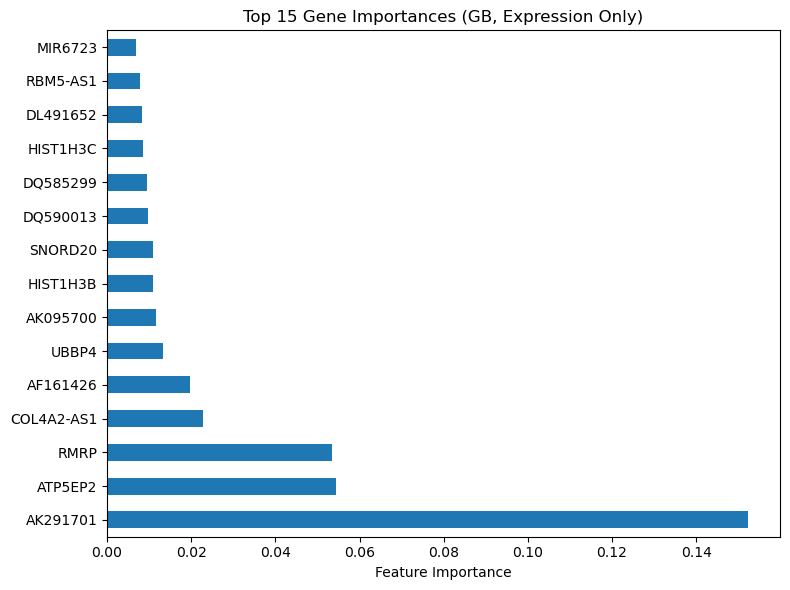

In [20]:
# Use only gene expression features (top 8000 most variable genes)
X_expr = expression_top.loc[y.index].fillna(expression_top.mean())
X_train_expr, X_test_expr, y_train_expr, y_test_expr = train_test_split(X_expr, y, test_size=0.2, random_state=42)

gb_expr = GradientBoostingRegressor(random_state=42)
gb_expr.fit(X_train_expr, y_train_expr)
y_pred_expr = gb_expr.predict(X_test_expr)

# Predicted vs Actual plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_expr, y_pred_expr, alpha=0.5)
plt.plot([y_test_expr.min(), y_test_expr.max()], [y_test_expr.min(), y_test_expr.max()], 'r--')
plt.xlabel('Actual Overall Survival Days')
plt.ylabel('Predicted Overall Survival Days')
plt.title('GB (Expression Only): Predicted vs Actual')
plt.tight_layout()
plt.show()

# Top 15 feature importances
importances_expr = pd.Series(gb_expr.feature_importances_, index=X_train_expr.columns)
top_importances_expr = importances_expr.sort_values(ascending=False).head(15)
top_importances_expr.plot(kind='barh', figsize=(8, 6))
plt.xlabel('Feature Importance')
plt.title('Top 15 Gene Importances (GB, Expression Only)')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

# Drop target from X if present
if target in combined.columns:
    combined = combined.drop(columns=[target])

# Target variable
y = clinical.loc[combined.index, target]

# Drop rows with missing target
combined = combined.loc[y.notnull()]
y = y.loc[y.notnull()]

# Fill missing values
X = combined.fillna(combined.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Try GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting - MSE: {mse_gb:.2f}, R^2: {r2_gb:.2f}')

Gradient Boosting - MSE: 57176.93, R^2: 0.77


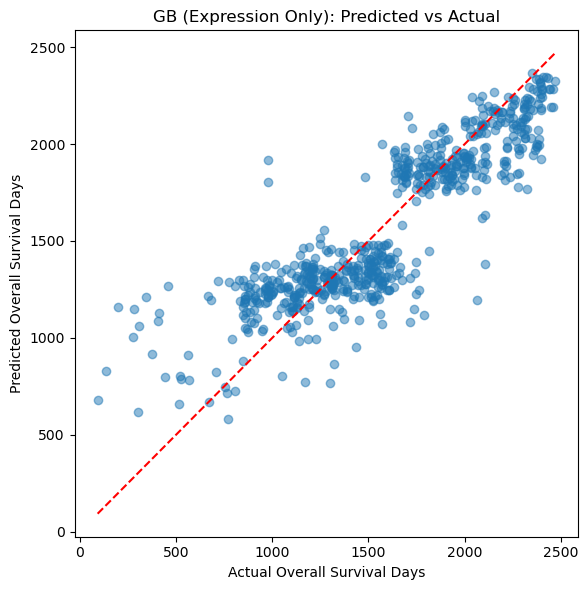

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Overall Survival Days')
plt.ylabel('Predicted Overall Survival Days')
plt.title('GB (Expression Only): Predicted vs Actual')
plt.tight_layout()
plt.show()

# Top 15 feature importances
importances = pd.Series(gb_model.feature_importances_, index=X_train.columns)
top_importances = importances.sort_values(ascending=False).head(15)
top_importances.plot(kind='barh', figsize=(8, 6))
plt.xlabel('Feature Importance')
plt.title('Top 15 Gene Importances (GB, Expression Only)')
plt.tight_layout()
plt.show()